In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
df = pd.read_csv('Reviews.csv',delimiter=',')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape # data shape

(568454, 10)

In [5]:
df.nunique() # check num of unique items per column

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [8]:
df["Sentiment"] = df["Score"].apply(lambda score: "Positive" if score > 3 else "Negative")
df.head(5)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [9]:
# check some statistics
print(df['Sentiment'].value_counts())

Positive    443777
Negative    124677
Name: Sentiment, dtype: int64


In [10]:
# clean duplicate rows
# remove rows that has duplicate values on UserId, ProfileName, Time, Text
final_df = df.drop_duplicates(subset=[
  'UserId','ProfileName','Time','Text'
])

In [11]:
final_df.shape

(393933, 11)

Select subcolumns

In [12]:
final_df = final_df[["Score", "Sentiment", "Summary", "Text"]]

Let's have a look at some 5s:

And some 1s as well:

In [13]:
final_df.head()

,Score,Sentiment,Summary,Text
0,5,Positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,Positive,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Negative,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Positive,Great taffy,Great taffy at a great price. There was a wid...


In [14]:
# find missing values 1
final_df.isnull().sum()

Score        0
Sentiment    0
Summary      3
Text         0
dtype: int64

In [15]:
# filling N/A with space
final_df.Summary.fillna(' ',inplace = True)

In [16]:
# find missing values 2
final_df.isnull().sum()

Score        0
Sentiment    0
Summary      0
Text         0
dtype: int64

In [17]:
final_df.head()

,Score,Sentiment,Summary,Text
0,5,Positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,Positive,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Negative,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Positive,Great taffy,Great taffy at a great price. There was a wid...


In [18]:
# text data cleaning
import re 
import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [19]:
def textovector(summary): 
      # select only text
      summary = re.sub('[^a-zA-Z]',' ',str(summary))
      summary = re.sub(r"http\S+", "", str(summary))
      # lower case 
      summary = summary.lower()
      split = summary.split()  
      res = [] 
      for i in split:  
    #  remove stopwords & stemmings    
    #  not remove stopwords such as 'not','no' which has a siginificant impact on reviews.
    #  summary = [PorterStemmer().stem(word) for word in summary if not word in set(stopwords.words('english'))]
          res.append(PorterStemmer().stem(i).strip())
#           res.append(i)  
      res = ' '.join(res)
      return res

In [20]:
print(textovector("Not as Advertised"))

not as advertis


In [21]:
# apply clean up function to values
final_df["Summary_Clean"] = final_df["Summary"].apply(textovector)

In [22]:
final_df.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,5,Positive,Good Quality Dog Food,I have bought several of the Vitality canned d...,good qualiti dog food
1,1,Negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not as advertis
2,4,Positive,"""Delight"" says it all",This is a confection that has been around a fe...,delight say it all
3,2,Negative,Cough Medicine,If you are looking for the secret ingredient i...,cough medicin
4,5,Positive,Great taffy,Great taffy at a great price. There was a wid...,great taffi


In [23]:
# define dependent and independent variables
X = final_df['Summary_Clean']

y = final_df['Sentiment']

In [24]:
# split the data into training set and a test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [25]:
# Bi-grams & n-grams & TFIDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer       

## Uni-gram BOW

In [26]:
# Uni-gram BOW
# Trainning set
cv = CountVectorizer()
X_train_uni = cv.fit_transform(X_train)    

# Testing set
X_test_uni = cv.transform(X_test)

In [27]:
prediction_uni = dict()

In [28]:
# logistic
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2',C=1,max_iter=500)
logreg.fit(X_train_uni,y_train)

# predicting the results
prediction_uni['Logistic'] = logreg.predict(X_test_uni)

# # model tuning and selection
# from sklearn.model_selection import GridSearchCV
# param_grid = [
#     {
#     'penalty' : ['l1', 'l2'],
#     'C' : np.logspace( 4, 20),
#     'max_iter' : [400,500]}
# ]

# # set up the grid search 
# grid_search = GridSearchCV(logreg, param_grid, cv=5,
#                           scoring='accuracy',
#                           return_train_score=True,
#                           n_jobs=-1)

# grid_search = grid_search.fit(X_train_uni, y_train)

# print('Best Score: ', grid_search.best_score_)
# print('Best Params: ', grid_search.best_params_)

# RandomForest
from sklearn.ensemble import RandomForestClassifier 
classifier_rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', n_jobs = -1)
classifier_rf.fit(X_train_uni,y_train)

# predicting the results
prediction_uni['RandomForest'] = classifier_rf.predict(X_test_uni)

In [29]:
from sklearn import metrics
from sklearn.metrics import plot_roc_curve, roc_curve, auc, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

# change y_test format:'negative' to 0
def formatt(x):
    if x == 'Negative':
        return 0
    return 1

# plot multiple roc curves
def multi_models_roc(names, sampling_methods, colors, X_test, y_test, save=True, dpin=100):
        """
        plor multiple model's roc into one figure
        
        Args:
            names: list, names for multiple models
            sampling_methods: list, instantiated objects for multiple models
            save: if save(PNG)
            
        Returns:
            return saved PNG
        """
        plt.figure(figsize=(10, 10), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            
            y_test_preds = method.predict(X_test)
            y_test_predprob = method.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test.map(formatt), y_test_predprob, pos_label=1)
            
            plt.plot(fpr, tpr, lw=5, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=5, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('False Positive Rate',fontsize=10)
            plt.ylabel('True Positive Rate',fontsize=10)
            plt.title('ROC Curve',fontsize=15)
            plt.legend(loc='lower right',fontsize=10)

        if save:
            plt.savefig('multi_models_roc.png')
            
        return plt


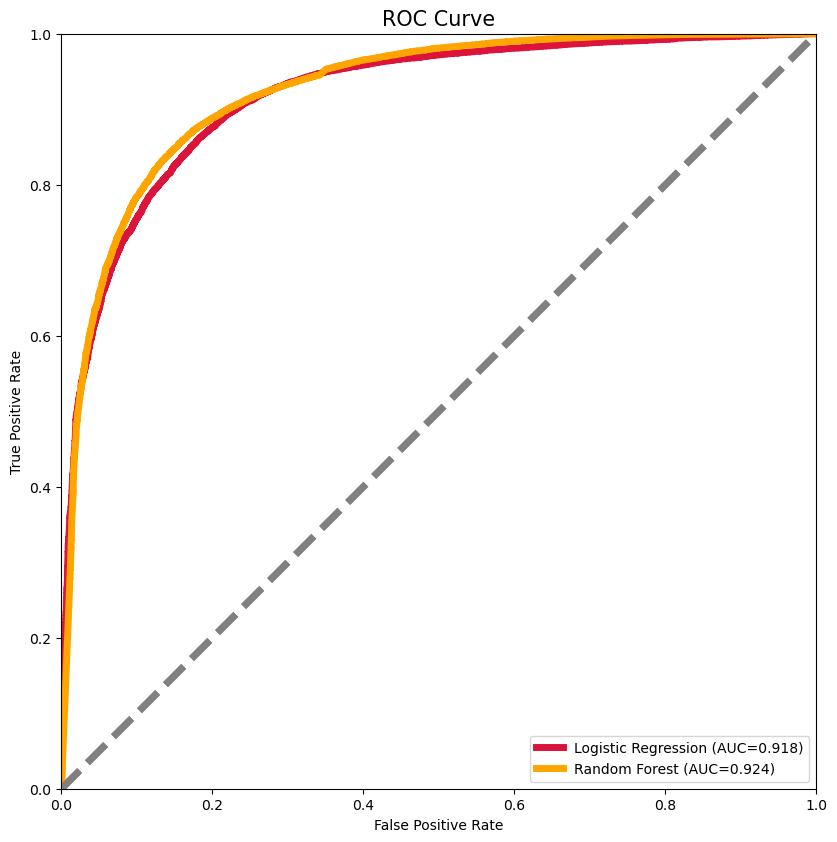

In [30]:
# apply roc curve plotting function
names = ['Logistic Regression',
         'Random Forest']

sampling_methods = [logreg,
                    classifier_rf,
                   ]

colors = ['crimson',
          'orange',
         ]

#ROC curves
train_roc_graph = multi_models_roc(names, sampling_methods, colors, X_test_uni, y_test, save = False)
train_roc_graph.savefig('ROC_Train_all.png')


In [31]:
# randomforest
rf_bow_report=classification_report(y_test,prediction_uni['RandomForest'])
print(rf_bow_report)

#Accuracy score for bag of words
rf_bow_score=accuracy_score(y_test,prediction_uni['RandomForest'])
print("rf_bow_score :",rf_bow_score)

              precision    recall  f1-score   support

    Negative       0.73      0.73      0.73     17476
    Positive       0.92      0.92      0.92     61311

    accuracy                           0.88     78787
   macro avg       0.83      0.83      0.83     78787
weighted avg       0.88      0.88      0.88     78787

rf_bow_score : 0.8799294299821037


## Bi-gram BOW

In [32]:
# Bi-gram BOW
# Trainning set
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True) # 1 means the minimum is unigram, 2 means max is bigrams, 
X_train_bi = bi_gram.fit_transform(X_train)    

# Testing set
X_test_bi = bi_gram.transform(X_test)

In [33]:
prediction_bi = dict()

In [34]:
# logistic
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2',C=1,max_iter=500)
logreg.fit(X_train_bi,y_train)

# predicting the results
prediction_bi['Logistic'] = logreg.predict(X_test_bi)

# RandomForest
from sklearn.ensemble import RandomForestClassifier 
classifier_rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', n_jobs = -1)
classifier_rf.fit(X_train_bi,y_train)

# predicting the results
prediction_bi['RandomForest'] = classifier_rf.predict(X_test_bi)

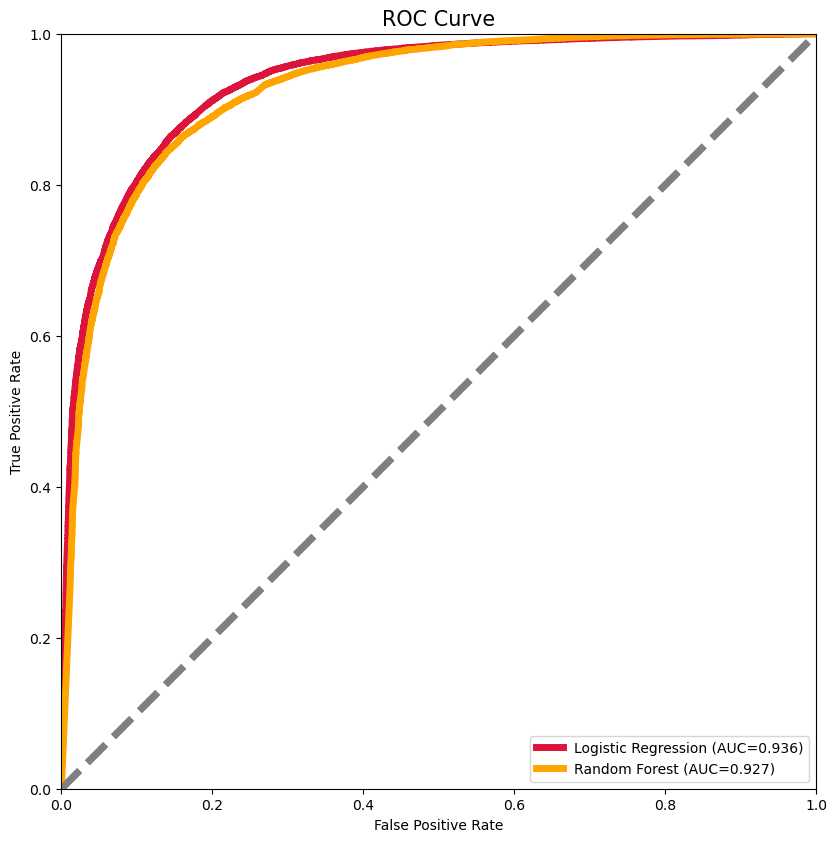

In [35]:
# apply roc curve plotting function
names = ['Logistic Regression',
         'Random Forest']

sampling_methods = [logreg,
                    classifier_rf,
                   ]

colors = ['crimson',
          'orange',
         ]

#ROC curves
train_roc_graph = multi_models_roc(names, sampling_methods, colors, X_test_bi, y_test, save = False)
train_roc_graph.savefig('ROC_Train_all.png')

In [36]:
# logistic
lg_bow_report=classification_report(y_test,prediction_bi['Logistic'])
print(lg_bow_report)

#Accuracy score for bag of words
lg_bow_score=accuracy_score(y_test,prediction_bi['Logistic'])
print("rf_bow_score :",lg_bow_score)

              precision    recall  f1-score   support

    Negative       0.83      0.69      0.75     17476
    Positive       0.91      0.96      0.94     61311

    accuracy                           0.90     78787
   macro avg       0.87      0.82      0.84     78787
weighted avg       0.90      0.90      0.90     78787

rf_bow_score : 0.899691573482935


## tf-idf

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Trainning set
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)
X_train_tfidf = tfidf.fit_transform(X_train)    

# Testing set
X_test_tfidf = tfidf.transform(X_test)

In [38]:
prediction_tfidf = dict()

In [39]:
# logistic
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2',C=1,max_iter=500)
logreg.fit(X_train_tfidf,y_train)

# predicting the results
prediction_tfidf['Logistic'] = logreg.predict(X_test_tfidf)

# RandomForest
from sklearn.ensemble import RandomForestClassifier 
classifier_rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', n_jobs = -1)
classifier_rf.fit(X_train_tfidf,y_train)

# predicting the results
prediction_tfidf['RandomForest'] = classifier_rf.predict(X_test_tfidf)

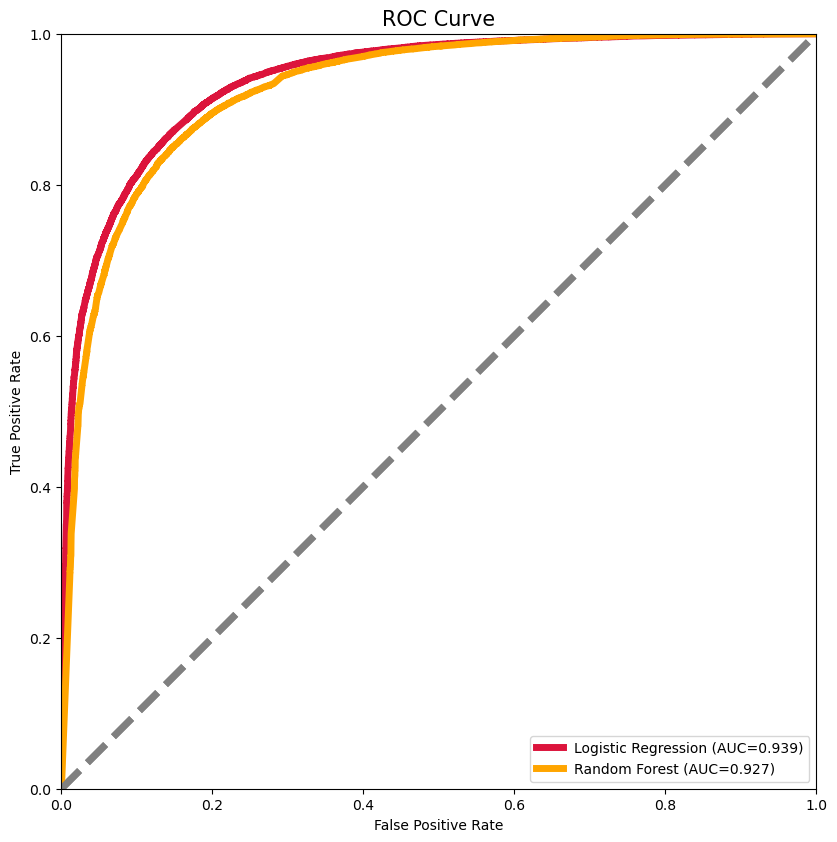

In [40]:
# apply roc curve plotting function
names = ['Logistic Regression',
         'Random Forest']

sampling_methods = [logreg,
                    classifier_rf,
                   ]

colors = ['crimson',
          'orange',
         ]

#ROC curves
train_roc_graph = multi_models_roc(names, sampling_methods, colors, X_test_tfidf, y_test, save = False)
train_roc_graph.savefig('ROC_Train_all.png')

In [41]:
# logistic
tfidf_bow_report=classification_report(y_test,prediction_tfidf['Logistic'])
print(tfidf_bow_report)

#Accuracy score for bag of words
tfidf_bow_score=accuracy_score(y_test,prediction_tfidf['Logistic'])
print("rf_bow_score :",tfidf_bow_score)

              precision    recall  f1-score   support

    Negative       0.84      0.67      0.75     17476
    Positive       0.91      0.96      0.94     61311

    accuracy                           0.90     78787
   macro avg       0.88      0.82      0.84     78787
weighted avg       0.90      0.90      0.89     78787

rf_bow_score : 0.8991331057154099
